In [1]:
from mylib.statistic_test import *

code_id = '0354 - Distribution of SNR'
loc = os.path.join(figpath, code_id)
mkdir(loc)

pass

d:\Software\Anaconda3\envs\maze\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


        D:\Data\FinalResults\0354 - Distribution of SNR is already existed!


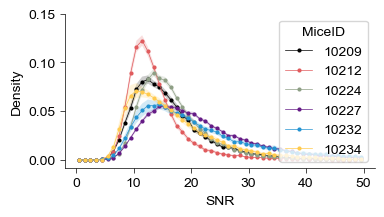

10209: 91 sessions
10212: 90 sessions
10224: 91 sessions
10227: 91 sessions
10232: 90 sessions
10234: 91 sessions


In [2]:
def get_noise_level(dFF: np.ndarray):
    thre = np.percentile(dFF, 97.5, axis=1)
    noise = np.zeros(dFF.shape[0]) * np.nan
    for i in range(dFF.shape[0]):
        noise[i] = np.std(dFF[i, dFF[i, :] < thre[i]])
    return noise

def compute_SNR(trace: dict) -> np.ndarray:
    raw_signal = trace['RawTraces']
    noise = get_noise_level(raw_signal)
    peak_amplitude = np.max(raw_signal, axis=1)
    SNR = peak_amplitude / noise
    return SNR

file_idx = np.where(
        (np.isin(f1['MiceID'], [10209, 10212, 10224, 10227, 10232, 10234])) &
        (f1['Stage'] != 'PRE') &
        (f1['include'] == 1)
)[0]
if exists(join(figdata, f"{code_id}.pkl")) == False:
    SNRData = {
        "MiceID": [],
        "Training Day": [],
        "Maze Type": [],
        "SNR": [],
        "Density": []
    }
    mazes = ['Open Field', 'Maze A', 'Maze B']
    idx = np.where(
        (np.isin(f1['MiceID'], [10209, 10212, 10224, 10227, 10232, 10234])) &
        (f1['Stage'] != 'PRE') &
        (f1['include'] == 1)
    )[0]
    for i in tqdm(idx):
        if exists(f1['Trace File'][i]):
            with open(f1['Trace File'][i], 'rb') as file:
                trace = pickle.load(file)
            
            SNR = compute_SNR(trace)
            snr_density, snr_bins = np.histogram(SNR, bins=50, range=(0, 50), density=True)
            snr_bins = (snr_bins[:-1] + snr_bins[1:]) / 2
            SNRData['MiceID'].append(np.repeat(int(f1['MiceID'][i]), len(snr_bins)))
            SNRData['Training Day'].append(np.repeat(f1['training_day'][i], len(snr_bins)))
            SNRData['Maze Type'].append(np.repeat(mazes[int(f1['maze_type'][i])], len(snr_bins)))
            SNRData['SNR'].append(snr_bins)
            SNRData['Density'].append(snr_density)
    
    for key in SNRData.keys():
        SNRData[key] = np.concatenate(SNRData[key])
        
    with open(join(figdata, f"{code_id}.pkl"), 'wb') as file:
        pickle.dump(SNRData, file)  
        
    SNRD = pd.DataFrame(SNRData)
    SNRD.to_excel(join(figdata, f"{code_id}.xlsx"), index=False)
    print(len(SNRD))
else:
    with open(join(figdata, f"{code_id}.pkl"), 'rb') as handle:
        SNRData = pickle.load(handle)

fig = plt.figure(figsize=(4, 2))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    x='SNR',
    y='Density',
    hue='MiceID',
    data=SNRData,
    palette=['k', '#e05b5d', '#8E9F85', '#651b86', '#2493d1', '#ffca4d'],
    linewidth=0.5,
    marker='o',
    markersize=3,
    markeredgewidth=0,
    err_kws={'edgecolor': None},
    ax=ax,
)
ax.set_ylim(-0.008, 0.15)
ax.set_yticks(np.linspace(0, 0.15, 4))
plt.savefig(join(loc, "Distribution of SNR for Each Session.png"), dpi=600)
plt.savefig(join(loc, "Distribution of SNR for Each Session.svg"))
plt.show()

for mouse in [10209, 10212, 10224, 10227, 10232, 10234]:
    print(f"{mouse}: {len(np.where(f1['MiceID'][file_idx] == mouse)[0])} sessions")

# Distribution of SNR in Tracked Neurons

300


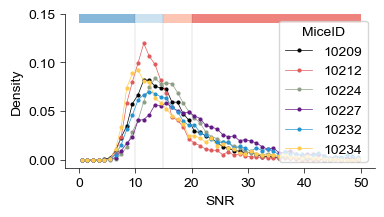

In [30]:
def get_snr_for_tracked_neurons(
    i: int,
    f: pd.DataFrame = f_CellReg_modi
):
    cellreg_dir = f['cellreg_folder'][i]
    mouse = int(f['MiceID'][i])
    stage = f['Stage'][i]
    session = int(f['session'][i])
    maze_type = int(f['maze_type'][i])
    behavior_paradigm = f['paradigm'][i]
    
    if behavior_paradigm == 'CrossMaze':
        fdata = f1
    elif behavior_paradigm == 'ReverseMaze':
        fdata = f3
    elif behavior_paradigm == 'HairpinMaze':
        fdata = f4
    else:
        raise ValueError(f"Paradigm {behavior_paradigm} is not supported.")

    file_indices = np.where((fdata['MiceID'] == mouse) & (fdata['Stage'] == stage) & (fdata['session'] == session))[0]
    
    if mouse in [11095, 11092]:
        file_indices = file_indices[3:]
    
    if stage == 'Stage 1+2':
        file_indices = np.where((fdata['MiceID'] == mouse) & (fdata['session'] == session) & ((fdata['Stage'] == 'Stage 1') | (fdata['Stage'] == 'Stage 2')))[0]
        
    if stage == 'Stage 1' and mouse in [10212] and session == 2:
        file_indices = np.where((fdata['MiceID'] == mouse) & (fdata['session'] == session) & (fdata['Stage'] == 'Stage 1') & (fdata['date'] != 20230506))[0]

    with open(f['Trace File'][i], 'rb') as handle:
        trace_mdays = pickle.load(handle)

    traces = []
    print(f"  Load Traces: ", end='')
    for j in tqdm(file_indices):
        with open(fdata['Trace File'][j], 'rb') as handle:
            trace = pickle.load(handle)

        trace['SNR'] = compute_SNR(trace)
        traces.append(trace)
        
    index_map = GetMultidayIndexmap(
        mouse,
        stage=stage,
        session=session,
        i = i,
        occu_num=2
    )
    index_map[np.where((np.isnan(index_map))|(index_map < 0))] = 0
    index_map = index_map.astype(np.int64)
    
    snr_mat = np.zeros_like(index_map, dtype=np.float64) * np.nan
    for s in range(index_map.shape[0]):
        cell_idx = np.where(index_map[s, :] > 0)[0]
        snr_mat[s, cell_idx] = traces[s]['SNR'][index_map[s, cell_idx] - 1]
        
    is_cell = np.where(index_map > 0, 1, 0)
    
    snr = []
    sample_len = []
    
    for i in range(index_map.shape[0]-1):
        for j in range(i+1, index_map.shape[0]):
            if i == 0:
                base_num = np.where((np.sum(is_cell[i:j, :], axis=0)==j-i)&(is_cell[j, :] == 0))[0]
                    
            elif i == 1:
                base_num = np.where((np.sum(is_cell[i:j, :], axis=0)==j-i)&(is_cell[j, :] == 0)&(is_cell[i-1, :] != 1))[0]
                
            else:
                base_num = np.where((np.sum(is_cell[i:j, :], axis=0)==j-i)&(is_cell[j, :] == 0)&
                                    (is_cell[i-1, :] == 0))[0]
            
            snr.append(np.nanmean(snr_mat[i:j, :][:, base_num], axis=0))
            sample_len.append(np.repeat(j-i, len(base_num)))
            
    return np.concatenate(snr), np.concatenate(sample_len)

if exists(join(figdata, f"{code_id} [Tracked Neurons].pkl")) == False:
    SNRTracked = {
        "MiceID": [],
        "Paradigm": [],
        "Cell Count": [],
        "SNR": []
    }
    
    for i in tqdm(range(len(f_CellReg_modi))):
        if f_CellReg_modi['Type'][i] != 'Real':
            continue
        
        if exists(f_CellReg_modi['Trace File'][i]) == False:
            continue
        
        snr_mat, cell_counts = get_snr_for_tracked_neurons(i, f_CellReg_modi)
        SNRTracked['MiceID'].append(np.repeat(int(f_CellReg_modi['MiceID'][i]), len(snr_mat)))
        SNRTracked['Paradigm'].append(np.repeat(f_CellReg_modi['paradigm'][i], len(snr_mat)))
        SNRTracked['Cell Count'].append(cell_counts)
        SNRTracked['SNR'].append(snr_mat)

    for key in SNRTracked.keys():
        SNRTracked[key] = np.concatenate(SNRTracked[key])
        
    with open(join(figdata, f"{code_id} [Tracked Neurons].pkl"), 'wb') as file:
        pickle.dump(SNRTracked, file)
        
    SNRD_Tracked = pd.DataFrame(SNRTracked)
    SNRD_Tracked.to_excel(join(figdata, f"{code_id} [Tracked Neurons].xlsx"), index=False)
    print(len(SNRD_Tracked))
else:
    with open(join(figdata, f"{code_id} [Tracked Neurons].pkl"), 'rb') as handle:
        SNRTracked = pickle.load(handle)

if exists(join(figdata, f" {code_id} [Tracked Neurons Density].pkl")) == False:
    SNRTrackedDensity = {
        "MiceID": [],
        "SNR": [],
        "Density": []
    }
    for mouse in [10209, 10212, 10224, 10227, 10232, 10234]:
        sub_data = SubDict(SNRTracked, SNRTracked.keys(), np.where((SNRTracked['MiceID'] == mouse))[0])
        if len(sub_data['SNR']) == 0:
            continue
            
        snr_density, snr_bins = np.histogram(sub_data['SNR'], bins=50, range=(0, 50), density=True)
        snr_bins = (snr_bins[:-1] + snr_bins[1:]) / 2
        SNRTrackedDensity['MiceID'].append(np.repeat(mouse, len(snr_bins)))
        SNRTrackedDensity['SNR'].append(snr_bins)
        SNRTrackedDensity['Density'].append(snr_density)
            
    for key in SNRTrackedDensity.keys():
        SNRTrackedDensity[key] = np.concatenate(SNRTrackedDensity[key])
        
    with open(join(figdata, f"{code_id} [Tracked Neurons Density].pkl"), 'wb') as file:
        pickle.dump(SNRTrackedDensity, file)
        
    SNRD_Tracked_Density = pd.DataFrame(SNRTrackedDensity)
    SNRD_Tracked_Density.to_excel(join(figdata, f"{code_id} [Tracked Neurons Density].xlsx"), index=False)
    print(len(SNRD_Tracked_Density))
else:
    with open(join(figdata, f"{code_id} [Tracked Neurons Density].pkl"), 'rb') as handle:
        SNRTrackedDensity = pickle.load(handle)

fig = plt.figure(figsize=(4, 2))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
SNRColors = sns.color_palette("Blues", 2)[::-1]+sns.color_palette("Reds", 2)
ax.fill_betweenx(y=[0.14, 0.15], x1=0, x2=10, color = SNRColors[0], alpha=0.6, edgecolor=None)
ax.fill_betweenx(y=[0.14, 0.15], x1=10, x2=15, color = SNRColors[1], alpha=0.6, edgecolor=None)
ax.fill_betweenx(y=[0.14, 0.15], x1=15, x2=20, color = SNRColors[2], alpha=0.6, edgecolor=None)
ax.fill_betweenx(y=[0.14, 0.15], x1=20, x2=50, color = SNRColors[3], alpha=0.6, edgecolor=None)
ax.axvline(x=10, color='k', linestyle='--', linewidth=0.1)
ax.axvline(x=15, color='k', linestyle='--', linewidth=0.1)
ax.axvline(x=20, color='k', linestyle='--', linewidth=0.1)
sns.lineplot(
    x='SNR',
    y='Density',
    hue='MiceID',
    data=SNRTrackedDensity,
    linewidth=0.5,
    marker='o',
    markersize=3,
    markeredgewidth=0,
    err_kws={'edgecolor': None},
    palette=['k', '#e05b5d', '#8E9F85', '#651b86', '#2493d1', '#ffca4d'],
    ax=ax
)
ax.set_ylim(-0.008, 0.15)
ax.set_yticks(np.linspace(0, 0.15, 4))
plt.savefig(join(loc, "Average SNR for Tracked Cells.png"), dpi=600)
plt.savefig(join(loc, "Average SNR for Tracked Cells.svg"))
plt.show()

In [ ]:
a = np.array([0, 1, 2, 3, 4])
b = np.digitize(a, bins=np.array([0.1, 2.3, 3.5]))
print(b.dtype)



int64
